<a href="https://colab.research.google.com/github/kunakl07/Backend-of-Active-Learning/blob/backend_v2/notebooks/active_learning/more_uncertain_active_learning_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Active Learning Notebook

## The training dataset consists of 1394 samples
## The active learning dataset consists of 176 samples
## The retraining dataset would consist of 1570 samples

## The test dataset consists of 201 samples


## Explanation in brief:

### In this notebook, I have taken the model is loaded which performs the predictions on the test data and the uncertian labels(i.e the calls with probabilities between 0.4 to 0.6) are passed to the user labeling.

### Since the model is confident that it has detected a call when the values of prediction is close to zero and it is confident that it has not predicted a call when the value is closer to 1. Therefore the values between 0.4 to 0.6 are the ones where the model is quite uncertian about and hence these calls are passed to the user for labeling.

### Importing the necessary libraries

In [4]:
import matplotlib
matplotlib.use("Agg")

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.applications import ResNet152V2
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from keras import models
from keras import layers
from keras import optimizers
from keras.applications import VGG16
from keras.applications import InceptionResNetV2
import sys, numpy
import os
from keras import optimizers, regularizers
from keras.layers import Dropout, Flatten, Dense, Activation, Input
from keras import callbacks, regularizers
from keras.models import load_model
import matplotlib.pyplot as plt 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.engine import  Model
from keras.layers import Conv2D, GlobalAveragePooling2D
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from keras import optimizers
from keras.applications import VGG16
from keras.applications import InceptionResNetV2
import sys, numpy
import os
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, regularizers
from keras.models import Sequential
from keras.models import load_model
import matplotlib.pyplot as plt 
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.engine import  Model
from keras.layers import Conv2D, GlobalAveragePooling2D
from sklearn import metrics
import itertools
import tensorflow as tf
import os

from google.colab import files
import datetime, os
%matplotlib inline

### Load the drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Extract the calls and no calls dataset on which predictions would be performed

In [6]:
!unzip '/content/drive/My Drive/pcen_wav_train_val.zip'

Archive:  /content/drive/My Drive/pcen_wav_train_val.zip
   creating: content/
   creating: content/Round2_OS_07_05/
   creating: content/Round2_OS_07_05/train/
   creating: content/Round2_OS_07_05/train/nocalls/
  inflating: content/Round2_OS_07_05/train/nocalls/neg_calls_pod333219_0000.png  
  inflating: content/Round2_OS_07_05/train/nocalls/neg_calls_pod333201_0000.png  
  inflating: content/Round2_OS_07_05/train/nocalls/neg_calls_pod260_0000.png  
  inflating: content/Round2_OS_07_05/train/nocalls/neg_calls_pod2305_0000.png  
  inflating: content/Round2_OS_07_05/train/nocalls/neg_calls_pod333427_0000.png  
  inflating: content/Round2_OS_07_05/train/nocalls/neg_calls_pod2250_0000.png  
  inflating: content/Round2_OS_07_05/train/nocalls/neg_calls_pod2135_0000.png  
  inflating: content/Round2_OS_07_05/train/nocalls/neg_calls_pod333116_0000.png  
  inflating: content/Round2_OS_07_05/train/nocalls/neg_calls_pod2202_0000.png  
  inflating: content/Round2_OS_07_05/train/nocalls/neg_calls

In [7]:
!unzip '/content/drive/My Drive/pcen_and_wavelet_test.zip'

Archive:  /content/drive/My Drive/pcen_and_wavelet_test.zip
   creating: content/Round2_OS_07_05/test/
   creating: content/Round2_OS_07_05/test/nocalls/
  inflating: content/Round2_OS_07_05/test/nocalls/calls_pod3_neg21_0000.png  
  inflating: content/Round2_OS_07_05/test/nocalls/calls_pod3_neg46_0000.png  
  inflating: content/Round2_OS_07_05/test/nocalls/calls_pod3_neg33_0000.png  
  inflating: content/Round2_OS_07_05/test/nocalls/calls_pod3_neg42_0000.png  
  inflating: content/Round2_OS_07_05/test/nocalls/calls_pod3_neg88_0000.png  
  inflating: content/Round2_OS_07_05/test/nocalls/calls_pod3_neg26_0000.png  
  inflating: content/Round2_OS_07_05/test/nocalls/calls_pod3_neg12_0000.png  
  inflating: content/Round2_OS_07_05/test/nocalls/calls_pod3_neg54_0000.png  
  inflating: content/Round2_OS_07_05/test/nocalls/calls_pod3_neg82_0000.png  
  inflating: content/Round2_OS_07_05/test/nocalls/calls_pod3_neg7_0000.png  
  inflating: content/Round2_OS_07_05/test/nocalls/calls_pod3_neg6_0

### Enter the data path as well as check the number of files

In [25]:
train_data_path = '/content/content/Round2_OS_07_05/train/'
validation_data_path='/content/content/Round2_OS_07_05/validation/'
test_data_path = '/content/content/Round2_OS_07_05/test/'
calls_path = '/content/content/Round2_OS_07_05/train/calls'

#Parametres
img_width, img_height = 607, 617

nb_test_samples = sum(len(files) for _, _, files in os.walk(test_data_path))
print(nb_test_samples)
epochs = 100
batch_size = 41
nb_call_samples = sum(len(files) for _, _, files in os.walk(calls_path))
print(nb_call_samples)

total_train_samples=sum(len(files) for _, _, files in os.walk("/content/content/Round2_OS_07_05/train/"))
total_al_samples=sum(len(files) for _, _, files in os.walk("/content/content/Round2_OS_07_05/active_learning/"))
print("Total train samples are:", total_train_samples)
print("Total active learning samples are:", total_al_samples)

201
698
Total train samples are: 1394
Total active learning samples are: 176


### Load the pretrained model

In [ ]:
model = keras.models.load_model('/content/srkw_100_epochs.h5')


### A thing to note here is that you cannot interchange the tf.keras.models.load_model and keras.models.load_models as there are some functions that are there is tf.keras which are not there is keras and viceversa

In [28]:
model=tf.keras.models.load_model("/content/drive/My Drive/Models/srkw_100_epochs.h5")

### Perform the probability prediction on the test dataset

In [37]:
al_datagen = ImageDataGenerator(rescale=1. / 255)


In [38]:
active_learning_data_generator = al_datagen.flow_from_directory(
    "/content/content/Round2_OS_07_05/active_learning",
     target_size=(img_width, img_height),
    batch_size=41,
    shuffle=False)

predictions_probab=model.predict_proba(active_learning_data_generator)


Found 176 images belonging to 2 classes.


### Here is the array of different probability predictions that I got on test dataset and if you see closely the ones in the beginning are

In [39]:
predictions_probab

array([[0.4358289 ],
       [0.36560276],
       [0.5152769 ],
       [0.7382855 ],
       [0.74729437],
       [0.34923506],
       [0.7985261 ],
       [0.8632383 ],
       [0.69601977],
       [0.6772678 ],
       [0.7375703 ],
       [0.8394731 ],
       [0.8408679 ],
       [0.7547285 ],
       [0.867315  ],
       [0.3580198 ],
       [0.5464989 ],
       [0.23553401],
       [0.22358227],
       [0.62601423],
       [0.6533484 ],
       [0.5398861 ],
       [0.33612618],
       [0.5711193 ],
       [0.61178845],
       [0.7094488 ],
       [0.24043263],
       [0.7843885 ],
       [0.2964298 ],
       [0.61158234],
       [0.4760732 ],
       [0.74979275],
       [0.734125  ],
       [0.20324194],
       [0.41668478],
       [0.71628034],
       [0.622519  ],
       [0.543767  ],
       [0.71016276],
       [0.35387006],
       [0.12372314],
       [0.35820073],
       [0.50473845],
       [0.6878395 ],
       [0.00946835],
       [0.7745515 ],
       [0.74911356],
       [0.144

### Converting from 2D array to 1D 

In [40]:
l=[]
l=predictions_probab[:,0]
l

array([0.4358289 , 0.36560276, 0.5152769 , 0.7382855 , 0.74729437,
       0.34923506, 0.7985261 , 0.8632383 , 0.69601977, 0.6772678 ,
       0.7375703 , 0.8394731 , 0.8408679 , 0.7547285 , 0.867315  ,
       0.3580198 , 0.5464989 , 0.23553401, 0.22358227, 0.62601423,
       0.6533484 , 0.5398861 , 0.33612618, 0.5711193 , 0.61178845,
       0.7094488 , 0.24043263, 0.7843885 , 0.2964298 , 0.61158234,
       0.4760732 , 0.74979275, 0.734125  , 0.20324194, 0.41668478,
       0.71628034, 0.622519  , 0.543767  , 0.71016276, 0.35387006,
       0.12372314, 0.35820073, 0.50473845, 0.6878395 , 0.00946835,
       0.7745515 , 0.74911356, 0.14483342, 0.59302616, 0.7134563 ,
       0.2129459 , 0.70575964, 0.30938187, 0.05683734, 0.0800145 ,
       0.22401665, 0.22589344, 0.47530055, 0.09980771, 0.48224735,
       0.04867376, 0.34748012, 0.91596097, 0.5844005 , 0.5222192 ,
       0.058325  , 0.6192997 , 0.4314097 , 0.47180414, 0.6259651 ,
       0.5147465 , 0.5765603 , 0.5060545 , 0.7629145 , 0.37197

### In this part of the code we are going to identify all the calls that the model is uncertain about and submit it to the user for labeling

In [41]:
i=0
j=0
count=0
confused_calls=[]
for ele in l:
    i=i+1
    if ele>0.1 and ele<0.9:
        confused_calls.append(i)   
        print(i)
        print(ele)
        count = count+1
print(count)

1
0.4358289
2
0.36560276
3
0.5152769
4
0.7382855
5
0.74729437
6
0.34923506
7
0.7985261
8
0.8632383
9
0.69601977
10
0.6772678
11
0.7375703
12
0.8394731
13
0.8408679
14
0.7547285
15
0.867315
16
0.3580198
17
0.5464989
18
0.23553401
19
0.22358227
20
0.62601423
21
0.6533484
22
0.5398861
23
0.33612618
24
0.5711193
25
0.61178845
26
0.7094488
27
0.24043263
28
0.7843885
29
0.2964298
30
0.61158234
31
0.4760732
32
0.74979275
33
0.734125
34
0.20324194
35
0.41668478
36
0.71628034
37
0.622519
38
0.543767
39
0.71016276
40
0.35387006
41
0.12372314
42
0.35820073
43
0.50473845
44
0.6878395
46
0.7745515
47
0.74911356
48
0.14483342
49
0.59302616
50
0.7134563
51
0.2129459
52
0.70575964
53
0.30938187
56
0.22401665
57
0.22589344
58
0.47530055
60
0.48224735
62
0.34748012
64
0.5844005
65
0.5222192
67
0.6192997
68
0.4314097
69
0.47180414
70
0.6259651
71
0.5147465
72
0.5765603
73
0.5060545
74
0.7629145
75
0.37197793
76
0.25190622
77
0.5048084
78
0.34614506
79
0.29986614
82
0.17793106
83
0.5749009
85
0.2531405
87

### There are 163 uncertain calls when the range of uncertain calls is between 0.1 to 0.9 

## Now we would place the calls that the model is more confident about in the train folder such that the calls predicted by the model could automatically go to the call folder in the training part and the no call predicted by the model would automatically go in the no call folder in the training part.

### Therefore, despite the call actually being call or no call if the model has predicted it as a call then it would go to the call folder for training and if the model has predicted it as no call it would go to the no call folder of the training part.

### Detecting the ids of the calls detected by the model

In [42]:
import numpy as np
i=0
j=0
count = 0
pred_call=[]
for ele in l:
    i=i+1
    if ele<0.1:
        pred_call.append(i)   
        print(i)
        print(ele)
        count=count+1
print(count)

45
0.009468346
54
0.056837335
55
0.080014504
59
0.09980771
61
0.048673756
66
0.058325004
80
0.02349886
81
0.010232319
84
0.061430134
86
0.0500152
88
0.007952931
92
0.04464439
12


### There are 12 confident calls

### Detecting the ids of the no calls predicted by the model.

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


In [70]:
import numpy as np
i=0
j=0
pred_call_neg=[]
for ele in l:
    i=i+1
    if ele>=0.9:
        pred_call_neg.append(i)   
        print(i)
        print(ele)
        folder_path="/content/content/Round2_OS_07_05/active_learning/nocalls/"
        onlyfiles = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        for id, file in enumerate(onlyfiles):
            if id==i:
               print(file)
               img = Image.open((os.path.join(folder_path, file)))


63
0.91596097
neg_calls_pod333339_0000.png


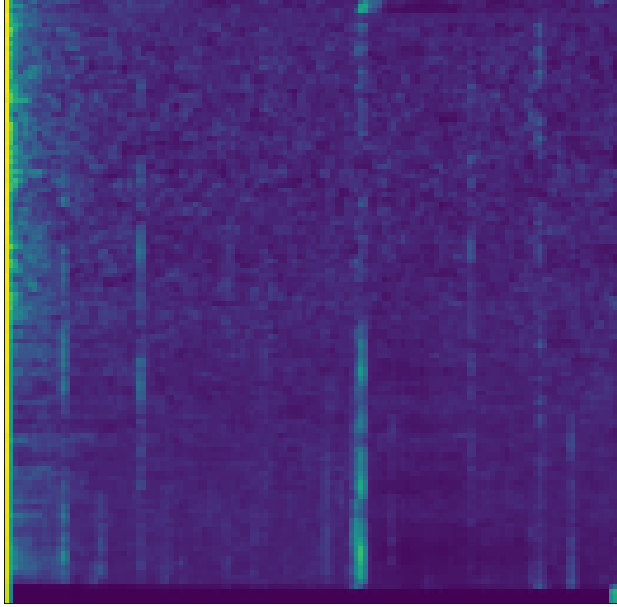

In [71]:
img

### There is one confident no call predicted by the model


In [76]:
import numpy as np
i=0
j=0
img=[]
count2=0
pred_call=[]
confident_file_name=[]
for ele in l:
    i=i+1
    if ele<0.1:
        pred_call.append(i)   
        print(i)
        print(ele)
        folder_path="/content/content/Round2_OS_07_05/active_learning/calls/"
        onlyfiles = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        for id, file in enumerate(onlyfiles):
            if id==i:
               count2=count2+1
               print(file)
               confident_file_name.append((os.path.join(folder_path, file)))               

45
0.009468346
calls53_0000.png
54
0.056837335
calls_pod3_pos319_0000.png
55
0.080014504
calls57_0000.png
59
0.09980771
calls43_0000.png
61
0.048673756
calls41_0000.png
66
0.058325004
calls63_0000.png
80
0.02349886
calls_pod3_pos286_0000.png
81
0.010232319
calls54_0000.png
84
0.061430134
calls_pod3_pos307_0000.png
86
0.0500152
calls_pod3_pos313_0000.png
88
0.007952931
92
0.04464439


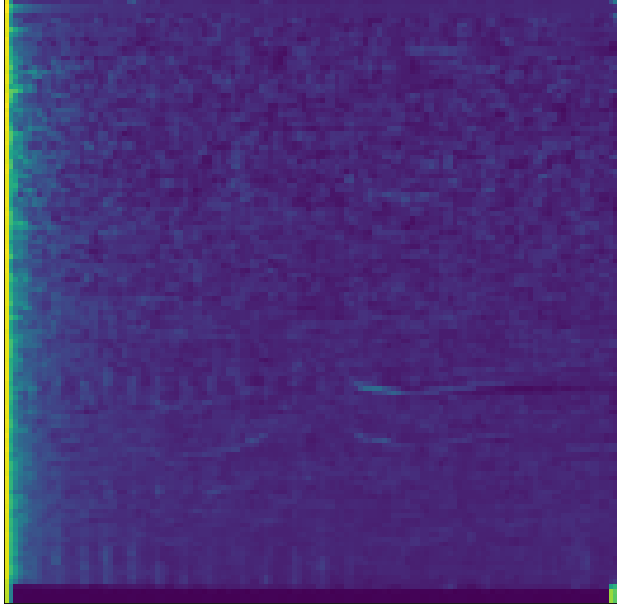

In [79]:
img = Image.open(confident_file_name[0])
img

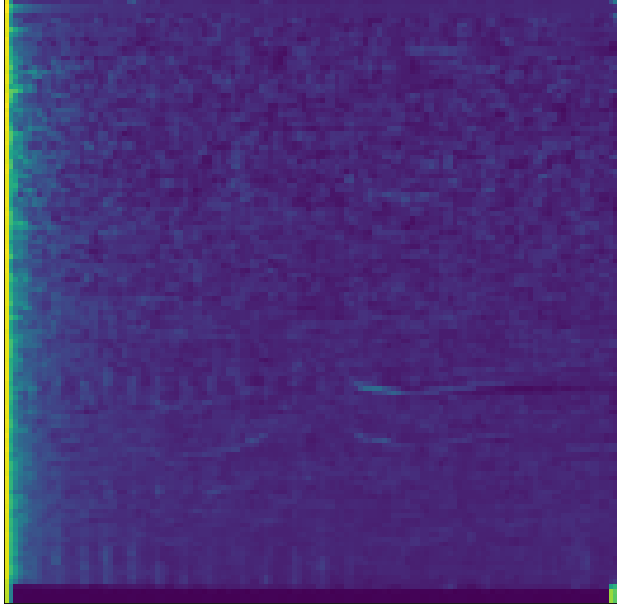

In [83]:
img = Image.open(confident_file_name[0])
img

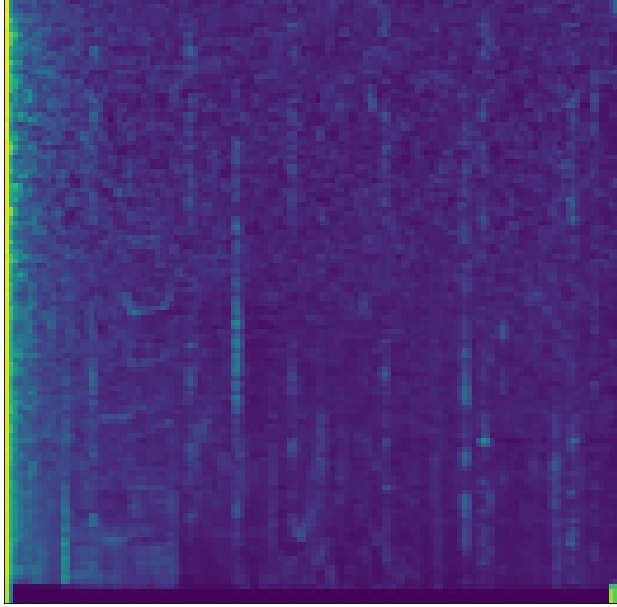

In [84]:
img = Image.open(confident_file_name[1])
img

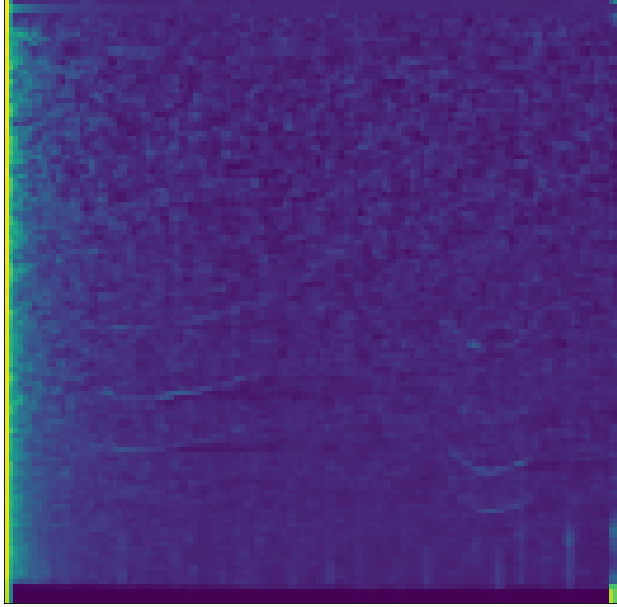

In [85]:
img = Image.open(confident_file_name[2])
img

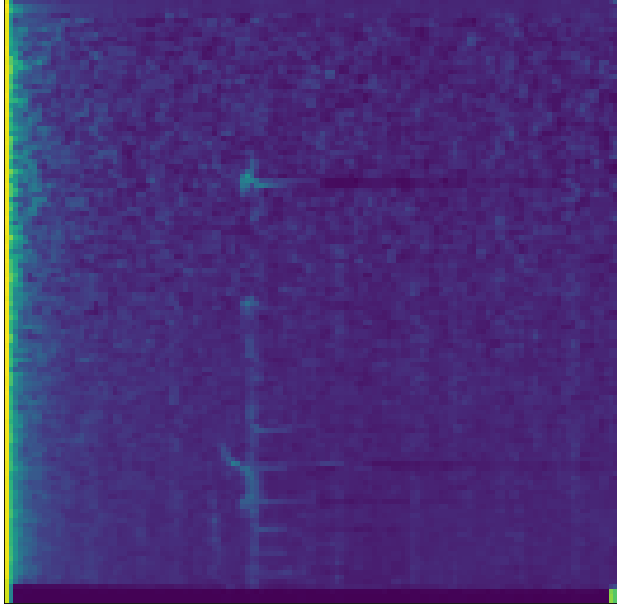

In [86]:
img = Image.open(confident_file_name[3])
img

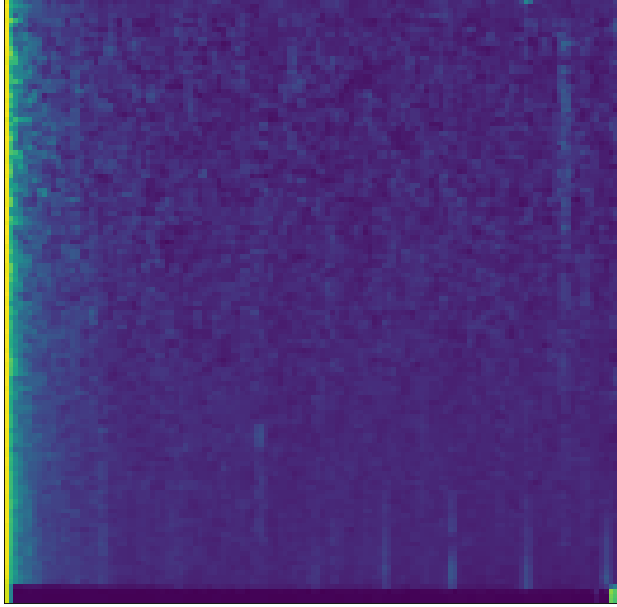

In [87]:
img = Image.open(confident_file_name[4])
img

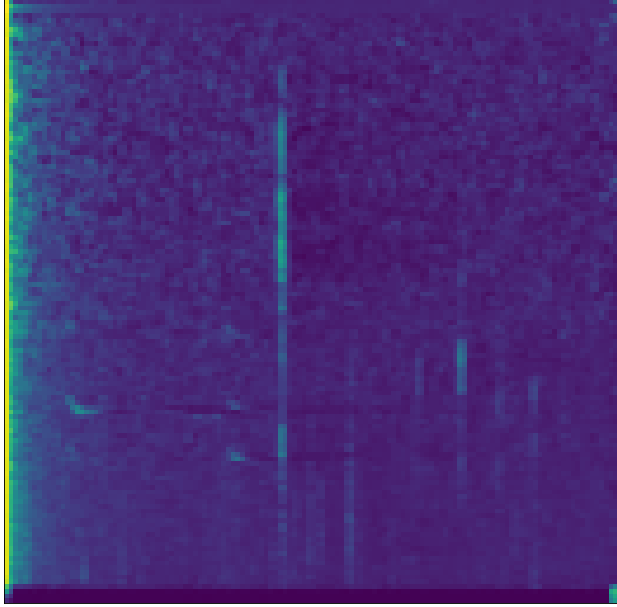

In [89]:
img = Image.open(confident_file_name[5])
img

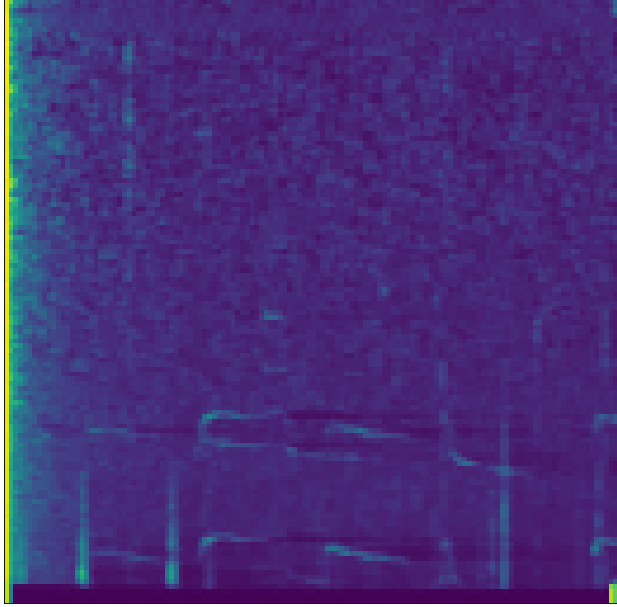

In [90]:
img = Image.open(confident_file_name[6])
img

### Create a list and append the ids of the calls that are to be labelled by the expert

In [91]:
al_pos_calls=[]
for ele in confused_calls:
    if(ele<88):
        al_pos_calls.append(ele)
al_pos_calls[:]

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 56,
 57,
 58,
 60,
 62,
 64,
 65,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 82,
 83,
 85,
 87]

In [92]:
import shutil

### Place the calls and no calls in the respective training folders for retraining again on these newly added data from the Active Learning dataset

In [93]:
onlyfiles = []
j=0
folder_path = "/content/content/Round2_OS_07_05/active_learning/calls/"
onlyfiles = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
for id, file in enumerate(onlyfiles):
    for j in al_pos_calls:
        if id == j:
            print(file)
            print(id)
            shutil.move(os.path.join(folder_path, file), "/content/content/Round2_OS_07_05/train/calls")

calls_pod3_pos311_0000.png
1
calls_pod3_pos293_0000.png
2
calls48_0000.png
3
calls_pod3_pos306_0000.png
4
calls39_0000.png
5
calls_pod3_pos305_0000.png
6
calls47_0000.png
7
calls46_0000.png
8
calls35_0000.png
9
calls_pod3_pos289_0000.png
10
calls68_0000.png
11
calls70_0000.png
12
calls75_0000.png
13
calls_pod3_pos303_0000.png
14
calls60_0000.png
15
calls_pod3_pos320_0000.png
16
calls_pod3_pos297_0000.png
17
calls_pod3_pos302_0000.png
18
calls61_0000.png
19
calls_pod3_pos300_0000.png
20
calls50_0000.png
21
calls_pod3_pos285_0000.png
22
calls72_0000.png
23
calls_pod3_pos309_0000.png
24
calls_pod3_pos284_0000.png
25
calls_pod3_pos301_0000.png
26
calls37_0000.png
27
calls_pod3_pos292_0000.png
28
calls76_0000.png
29
calls_pod3_pos318_0000.png
30
calls_pod3_pos288_0000.png
31
calls62_0000.png
32
calls_pod3_pos304_0000.png
33
calls34_0000.png
34
calls_pod3_pos314_0000.png
35
calls_pod3_pos298_0000.png
36
calls58_0000.png
37
calls67_0000.png
38
calls_pod3_pos296_0000.png
39
calls52_0000.png
40

In [94]:
al_neg_calls=[]
for ele in confused_calls:
    if(ele>88):
        al_neg_calls.append(ele)
al_neg_calls[:]

[89,
 90,
 91,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176]

In [96]:
onlyfiles = []
j=0
folder_path = "/content/content/Round2_OS_07_05/active_learning/nocalls/"
onlyfiles = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
for id, file in enumerate(onlyfiles):
    for j in al_neg_calls:
        if id+88 == j:
            print(file)
            print(id)
            shutil.move(os.path.join(folder_path, file), "/content/content/Round2_OS_07_05/train/nocalls")

neg_calls_pod333368_0000.png
1
neg_calls_pod333378_0000.png
2
neg_calls_pod333348_0000.png
3
neg_calls_pod229_0000.png
5
neg_calls_pod333360_0000.png
6
neg_calls_pod243_0000.png
7
neg_calls_pod237_0000.png
8
neg_calls_pod333356_0000.png
9
neg_calls_pod255_0000.png
10
neg_calls_pod223_0000.png
11
neg_calls_pod333358_0000.png
12
neg_calls_pod333346_0000.png
13
neg_calls_pod333379_0000.png
14
neg_calls_pod333345_0000.png
15
neg_calls_pod333354_0000.png
16
neg_calls_pod333355_0000.png
17
neg_calls_pod333373_0000.png
18
neg_calls_pod221_0000.png
19
neg_calls_pod246_0000.png
20
neg_calls_pod333344_0000.png
21
neg_calls_pod333362_0000.png
22
neg_calls_pod333367_0000.png
23
neg_calls_pod333363_0000.png
24
neg_calls_pod245_0000.png
25
neg_calls_pod333352_0000.png
26
neg_calls_pod235_0000.png
27
neg_calls_pod333359_0000.png
28
neg_calls_pod213_0000.png
29
neg_calls_pod242_0000.png
30
neg_calls_pod253_0000.png
31
neg_calls_pod251_0000.png
32
neg_calls_pod333370_0000.png
33
neg_calls_pod333338_000

In [97]:
pred_call

[45, 54, 55, 59, 61, 66, 80, 81, 84, 86, 88, 92]

### Currently I am just training the model based on the predicted samples by the active learning library

### Check the number of training samples after active learning


In [100]:
nb_train_samples = sum(len(files) for _, _, files in os.walk("/content/content/Round2_OS_07_05/train"))
print("The number of train samples after active learning", nb_train_samples)


The number of train samples after active learning 1556


In [101]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

train_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)
train_batchsize = 41
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(img_width, img_height),
    batch_size=train_batchsize,
    class_mode='binary',
shuffle=True)
val_batchsize =32


logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,

    epochs=150,
    )
model.save('AL_srkw_done_0.1_0.9_samples.h5')

Found 1556 images belonging to 2 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/150
37/37 [==============================] - 19s 520ms/step - loss: 0.6010 - accuracy: 0.7578
Epoch 2/150
37/37 [==============================] - 19s 524ms/step - loss: 0.5971 - accuracy: 0.7663
Epoch 3/150
37/37 [==============================] - 19s 515ms/step - loss: 0.5879 - accuracy: 0.7657
Epoch 4/150
37/37 [==============================] - 19s 515ms/step - loss: 0.5749 - accuracy: 0.7835
Epoch 5/150
37/37 [==============================] - 19s 519ms/step - loss: 0.5752 - accuracy: 0.7726
Epoch 6/150
37/37 [==============================] - 20s 534ms/step - loss: 0.5712 - accuracy: 0.7729
Epoch 7/150
37/37 [==============================] - 20s 534ms/step - loss: 0.5479 - accuracy: 0.7927
Epoch 8/150
37/37 [==============================] - 20s 535ms/step - loss: 0.5471 - accuracy: 0.7927
Epoch 9/150
37/37 [==============================] - 20s 532ms/ste

KeyboardInterrupt: ignored

### The accuracy on the test dataset after active learning

In [103]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
from sklearn.metrics import confusion_matrix
import numpy as np

test_generator = ImageDataGenerator()
test_data_generator = test_datagen.flow_from_directory(
    test_data_path,
     target_size=(img_width, img_height),
    batch_size=41,
    shuffle=False)
test_steps_per_epoch = numpy.math.ceil(test_data_generator.samples / test_data_generator.batch_size)


predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch)
predictions[predictions<=0.5] = 0
predictions[predictions>0.5] = 1

predicted_classes = (predictions).astype(np.int)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())   

report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

cm = confusion_matrix(true_classes, predicted_classes)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

Found 201 images belonging to 2 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
              precision    recall  f1-score   support

       calls       0.90      0.77      0.83       101
     nocalls       0.80      0.91      0.85       100

    accuracy                           0.84       201
   macro avg       0.85      0.84      0.84       201
weighted avg       0.85      0.84      0.84       201

[[78 23]
 [ 9 91]]
acc: 0.8408
sensitivity: 0.7723
specificity: 0.9100


### The accuracy of the test dataset after active learning is 84%

###Now let's see the accuracy of the model before active learning on the test set

In [104]:
model2=keras.models.load_model("/content/drive/My Drive/Models/srkw_100_epochs.h5")

In [105]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
from sklearn.metrics import confusion_matrix
import numpy as np

test_generator = ImageDataGenerator()
test_data_generator = test_datagen.flow_from_directory(
    test_data_path,
     target_size=(img_width, img_height),
    batch_size=41,
    shuffle=False)
test_steps_per_epoch = numpy.math.ceil(test_data_generator.samples / test_data_generator.batch_size)


predictions = model2.predict_generator(test_data_generator, steps=test_steps_per_epoch)
predictions[predictions<=0.5] = 0
predictions[predictions>0.5] = 1

predicted_classes = (predictions).astype(np.int)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())   

report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

cm = confusion_matrix(true_classes, predicted_classes)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

Found 201 images belonging to 2 classes.
              precision    recall  f1-score   support

       calls       0.85      0.79      0.82       101
     nocalls       0.80      0.86      0.83       100

    accuracy                           0.83       201
   macro avg       0.83      0.83      0.83       201
weighted avg       0.83      0.83      0.83       201

[[80 21]
 [14 86]]
acc: 0.8259
sensitivity: 0.7921
specificity: 0.8600


### The accuracy of the model on the test set before active learning is 82.5%